In [111]:
%pip install pandas
%pip install scipy
import matplotlib.pyplot as plt
import numpy as np
import yt
import matplotlib.cm as cm
#from plot_variables import *
from yt.utilities.math_utils import ortho_find
from helper_functions import *
from helper_functions import _h2_fraction

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [112]:
from yt.data_objects.level_sets.api import * # for clump finding

In [113]:
ds = yt.load("/disk14/sgordon/pleiades-11-12-23/seed1-bh-only/270msun/replicating-beckmann/1B.RSb01-2/DD0410/DD0410")
ds.add_field(("gas", "h2_fraction"), function=_h2_fraction, units="dimensionless", display_name="H2 Fraction", sampling_type="cell")

yt : [INFO     ] 2024-02-20 17:08:54,525 Parameters: current_time              = 17.084240249306
yt : [INFO     ] 2024-02-20 17:08:54,526 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-02-20 17:08:54,528 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-02-20 17:08:54,529 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-02-20 17:08:54,530 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-02-20 17:08:54,531 Parameters: current_redshift          = 22.836750786834
yt : [INFO     ] 2024-02-20 17:08:54,532 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-02-20 17:08:54,532 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-02-20 17:08:54,533 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-02-20 17:08:54,534 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 3409/3409 [00:00<00:00, 4512.12it/s]
yt : [INFO     ] 2024-02-20

In [126]:
# Make initial master clump (a disk containing the clump)
ss_pos, ss_mass, ss_age = ss_properties(ds, velocity=False)
L = [1, 0, 0]
clump_pos = ss_pos.to('pc') + [-2, 2, -2]*yt.units.pc
data_source = ds.disk(clump_pos, L, (1, "pc"), (1, "pc"))
master_clump = Clump(data_source, ("gas", "density"))

ds =  DD0410


In [115]:
# Add clump validators (refine clump properties)
# master_clump.add_validator("min_cells", 20)
# master_clump.add_validator("gravitationally_bound", use_particles=False)

# def _minimum_gas_mass(clump, min_mass):
#     return clump["gas", "mass"].sum() >= min_mass
# add_validator("minimum_gas_mass", _minimum_gas_mass)
# master_clump.add_validator("minimum_gas_mass", ds.quan(0.05, "Msun"))

In [127]:
# Find clumps
c_min = data_source["gas", "density"].min()
c_max = data_source["gas", "density"].max()
step = 1.5
find_clumps(master_clump, c_min, c_max, step)

yt : [INFO     ] 2024-02-20 17:19:20,049 Finding clumps: min: 7.026509e-24, max: 1.383177e-16, step: 1.500000
yt : [INFO     ] 2024-02-20 17:19:20,582 Linking node (284) contours.
yt : [INFO     ] 2024-02-20 17:19:21,420 Linked.
Updating joins ... : 100%|██████████| 284/284 [00:00<00:00, 17254.26it/s]
yt : [INFO     ] 2024-02-20 17:19:21,508 Finding clumps: min: 1.053976e-23, max: 1.383177e-16, step: 1.500000
yt : [INFO     ] 2024-02-20 17:19:21,509 Wiping out existing children clumps: 1.
yt : [INFO     ] 2024-02-20 17:19:21,606 Linking node (284) contours.
yt : [INFO     ] 2024-02-20 17:19:22,438 Linked.
Updating joins ... : 100%|██████████| 284/284 [00:00<00:00, 15996.11it/s]
yt : [INFO     ] 2024-02-20 17:19:22,525 Finding clumps: min: 1.580965e-23, max: 1.383177e-16, step: 1.500000
yt : [INFO     ] 2024-02-20 17:19:22,526 Wiping out existing children clumps: 1.
yt : [INFO     ] 2024-02-20 17:19:22,631 Linking node (284) contours.
yt : [INFO     ] 2024-02-20 17:19:23,437 Linked.
Upd

In [128]:
#print(master_clump.children)
print(master_clump.children[0]["gas", "density"])

[9.42779056e-23 8.01542852e-23 8.30968396e-23 ... 5.20587766e-21
 5.18722935e-21 5.20657657e-21] g/cm**3


In [146]:
leaf_clumps = master_clump.leaves
len(leaf_clumps)

12

In [150]:
max_clump = np.array(0.)*yt.units.Msun
for i in range(len(leaf_clumps)):
    clump_mass = np.sum(leaf_clumps[i].quantities.total_mass().to('Msun'))
    print("clump {i} mass: {mass}".format(i=i, mass=clump_mass))    
    max_clump = np.max(np.sum(max_clump), np.sum(clump_mass))

clump 0 mass: 12.201934264404661 Msun


TypeError: only integer scalar arrays can be converted to a scalar index

In [149]:
max_clump = np.array([2., 1.])*yt.units.Msun
np.sum(max_clump)

unyt_quantity(3., 'Msun')

yt : [INFO     ] 2024-02-20 17:22:15,815 Projection completed
yt : [INFO     ] 2024-02-20 17:22:15,819 xlim = 0.492908 0.493111
yt : [INFO     ] 2024-02-20 17:22:15,821 ylim = 0.508255 0.508458
yt : [INFO     ] 2024-02-20 17:22:15,826 xlim = 0.492908 0.493111
yt : [INFO     ] 2024-02-20 17:22:15,827 ylim = 0.508255 0.508458
yt : [INFO     ] 2024-02-20 17:22:15,829 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800
yt : [INFO     ] 2024-02-20 17:22:16,835 Pixelizing contour 0
yt : [INFO     ] 2024-02-20 17:22:17,310 Pixelizing contour 1
yt : [INFO     ] 2024-02-20 17:22:17,315 Pixelizing contour 2
yt : [INFO     ] 2024-02-20 17:22:17,318 Pixelizing contour 3
yt : [INFO     ] 2024-02-20 17:22:17,322 Pixelizing contour 4
yt : [INFO     ] 2024-02-20 17:22:17,325 Pixelizing contour 5
yt : [INFO     ] 2024-02-20 17:22:17,329 Pixelizing contour 6
yt : [INFO     ] 2024-02-20 17:22:17,332 Pixelizing contour 7
yt : [INFO     ] 2024-02-20 17:22:17,335 Pixelizing contour 8



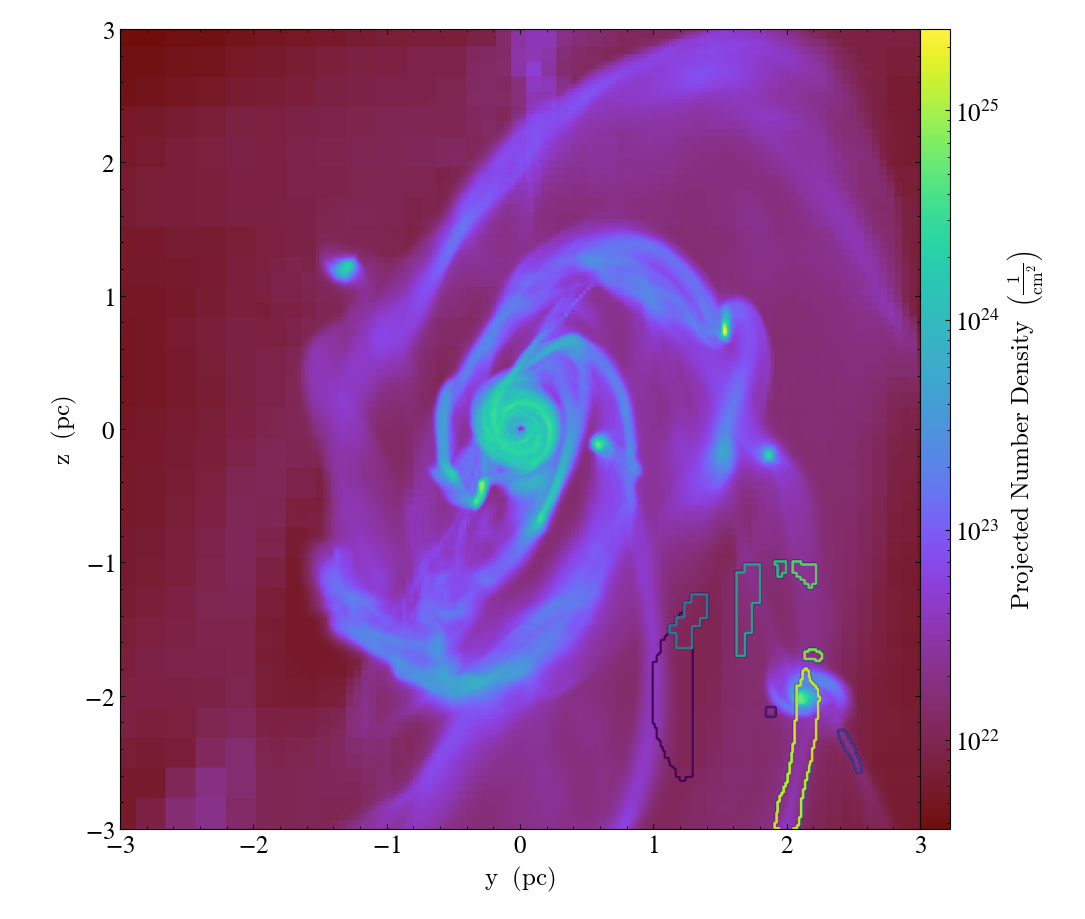

In [131]:
prj = yt.ProjectionPlot(ds, 0, ("gas", "number_density"), center=ss_pos, width=(6, "pc"))
prj.annotate_clumps(leaf_clumps)
prj.show()

yt : [INFO     ] 2024-02-20 17:22:57,011 Projection completed
yt : [INFO     ] 2024-02-20 17:22:57,014 xlim = 0.488274 0.488477
yt : [INFO     ] 2024-02-20 17:22:57,014 ylim = 0.492908 0.493111
yt : [INFO     ] 2024-02-20 17:22:57,017 xlim = 0.488274 0.488477
yt : [INFO     ] 2024-02-20 17:22:57,018 ylim = 0.492908 0.493111
yt : [INFO     ] 2024-02-20 17:22:57,019 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800
yt : [INFO     ] 2024-02-20 17:22:57,499 Pixelizing contour 0
yt : [INFO     ] 2024-02-20 17:22:57,903 Pixelizing contour 1
yt : [INFO     ] 2024-02-20 17:22:57,907 Pixelizing contour 2
yt : [INFO     ] 2024-02-20 17:22:57,911 Pixelizing contour 3
yt : [INFO     ] 2024-02-20 17:22:57,914 Pixelizing contour 4
yt : [INFO     ] 2024-02-20 17:22:57,917 Pixelizing contour 5
yt : [INFO     ] 2024-02-20 17:22:57,920 Pixelizing contour 6
yt : [INFO     ] 2024-02-20 17:22:57,923 Pixelizing contour 7
yt : [INFO     ] 2024-02-20 17:22:57,926 Pixelizing contour 8



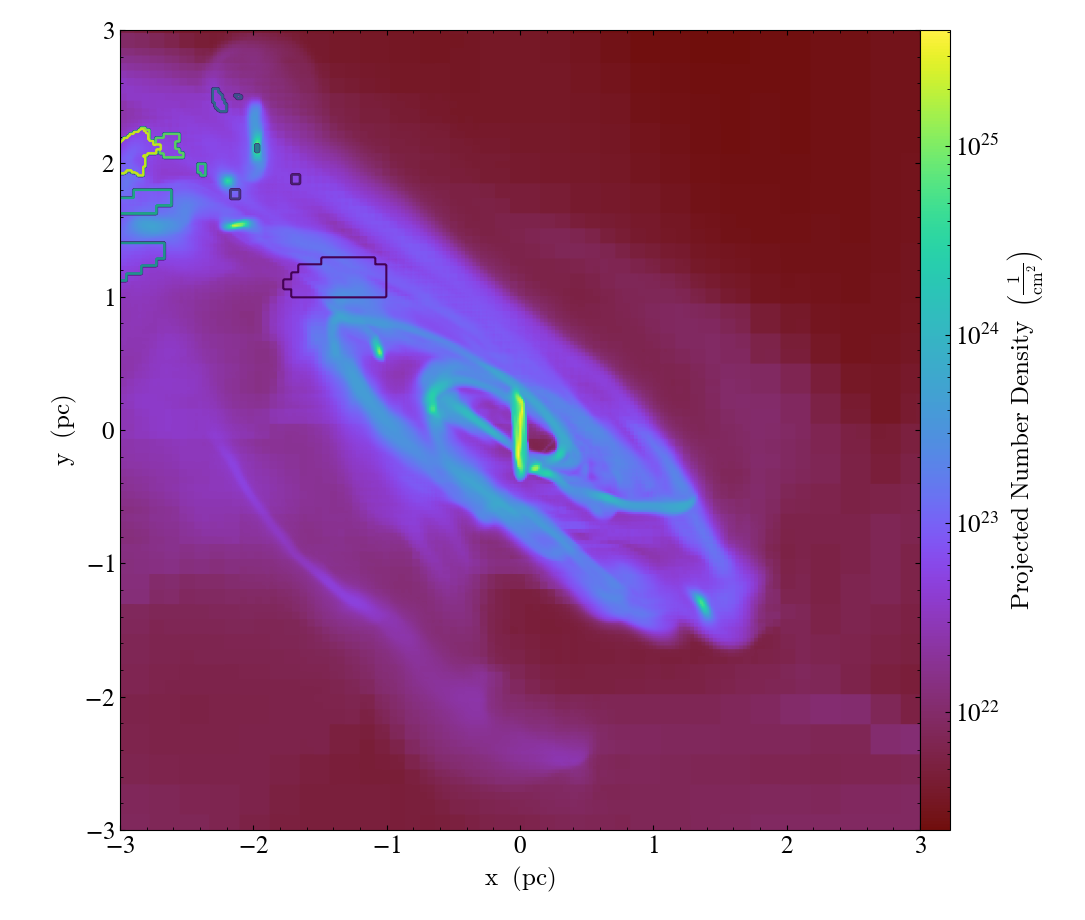

In [132]:
prj = yt.ProjectionPlot(ds, 2, ("gas", "number_density"), center=ss_pos, width=(6, "pc"))
prj.annotate_clumps(leaf_clumps)
prj.show()

In [133]:
for clump in master_clump:
    print(clump.clump_id)

0
7
10
16
20
23
25
28
29
30
26
24
21
17
41
43
64
44
42
18
11
8


In [134]:
# Get a list of just the leaf nodes.
leaf_clumps = master_clump.leaves

print(leaf_clumps[0]["gas", "density"])
print(leaf_clumps[0]["all", "particle_mass"])
print(leaf_clumps[0].quantities.total_mass().to('Msun'))

[2.90089182e-20 2.68214004e-20 2.38564678e-20 ... 2.37971945e-20
 2.40944528e-20 2.38549616e-20] g/cm**3
[] g
[12.20193426  0.        ] Msun


In [137]:
my_clump = leaf_clumps[0]
print(my_clump["gas", "mass"]) # the mass of each cell in the clump
print(my_clump["gas", "density"]) 
print(my_clump["gas", "temperature"])

[2.38279808e+30 2.20311495e+30 1.95957482e+30 ... 1.95470610e+30
 1.97912295e+30 1.95945110e+30] g
[2.90089182e-20 2.68214004e-20 2.38564678e-20 ... 2.37971945e-20
 2.40944528e-20 2.38549616e-20] g/cm**3
[50.4672334  56.37485971 58.64919192 ... 39.53497857 33.74115713
 34.1731491 ] K


In [138]:
print(my_clump["gas", "h2_fraction"])

[0.01076823 0.01066531 0.01021996 ... 0.01125365 0.01144217 0.0114393 ] dimensionless
